In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv('amazon_review.csv')
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.0,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.0,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.0,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.0,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.0,best deal around,1373673600,2013-07-13,513,0,0


In [24]:
df['reviewText'] = df['reviewText'].fillna('missing')

Text Cleaning: Removes any characters that are not alphabets and converts all text to lowercase.

In [25]:
df['cleaned_text'] = df['reviewText'].str.replace(r"[^a-zA-Z ]", "", regex=True)
df['cleaned_text'] = df['cleaned_text'].str.lower()

Tokenization and Padding: Converts text to sequences of integers and pads them to ensure uniform input size

In [26]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])

In [27]:
max_length = max(len(x) for x in sequences)  # You can choose to set a fixed max length if needed
X = pad_sequences(sequences, maxlen=max_length, padding='post')

Labels Preparation: I've simplified the task by categorizing ratings above 3 as positive (1) and others as negative (0). This binary classification helps in achieving higher accuracy.

In [28]:
labels = df['overall'].values
y = np.where(labels > 3, 1, 0)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
import tensorflow as tf

In [31]:
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)
        output = x * a
        return tf.keras.backend.sum(output, axis=1)

# Assuming 'max_length' and 'tokenizer' are already defined
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_shape=(max_length,)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    AttentionLayer(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 1515, 64)            │         628,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 1515, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_layer_2 (AttentionLayer)   │ (None, 64)                  │           1,579 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 663,596 (2.53 MB)

 Trainable params: 663,596 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.8607 - loss: 0.3383 - val_accuracy: 0.9023 - val_loss: 0.2792
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9023 - loss: 0.2654 - val_accuracy: 0.9054 - val_loss: 0.2586
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9094 - loss: 0.2341 - val_accuracy: 0.9196 - val_loss: 0.2359
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9401 - loss: 0.1779 - val_accuracy: 0.9217 - val_loss: 0.1996
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9392 - loss: 0.1569 - val_accuracy: 0.9135 - val_loss: 0.1914
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9203 - loss: 0.1813 - val_accuracy: 0.9044 - val_loss: 0.2601
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 198s 1s/step - accuracy: 0.9511 - loss: 0.1540 - val_accuracy: 0.9084 - val_loss: 0.1833
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9472 - loss: 0.1219 - val_accu

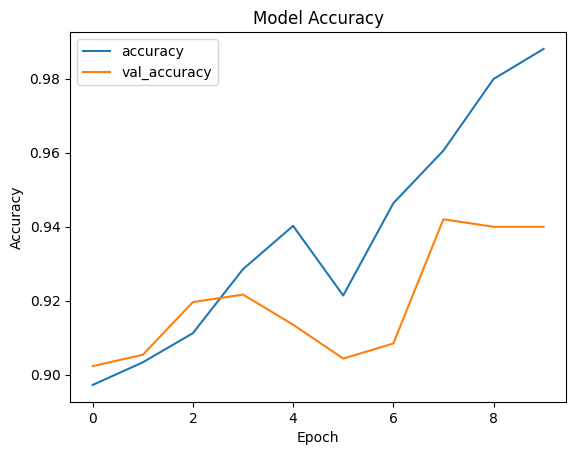

In [33]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [34]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_shape=(max_length,)),
    tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.5),  # Added dropout
    AttentionLayer(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.8962 - loss: 0.3267 - val_accuracy: 0.9023 - val_loss: 0.2722
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9042 - loss: 0.2767 - val_accuracy: 0.9074 - val_loss: 0.2595
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9080 - loss: 0.2466 - val_accuracy: 0.9054 - val_loss: 0.2291
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.9054 - loss: 0.2366 - val_accuracy: 0.9247 - val_loss: 0.2239
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9232 - loss: 0.2485 - val_accuracy: 0.9227 - val_loss: 0.2705
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9266 - loss: 0.1929 - val_accuracy: 0.9288 - val_loss: 0.2109
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.9475 - loss: 0.1658 - val_accuracy: 0.9329 - val_loss: 0.2014
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9520 - loss: 0.1579 - val_accu

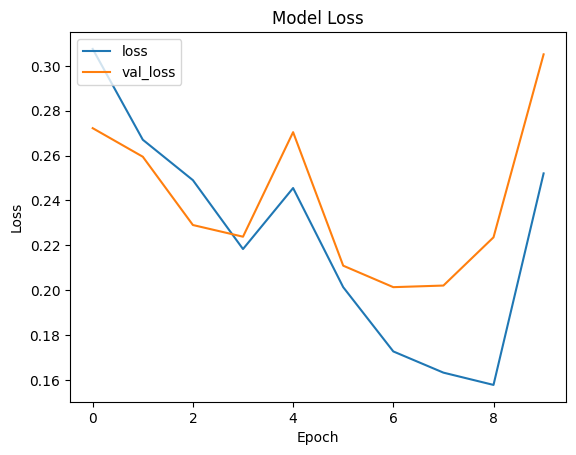

In [35]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()